# Transfer Learning Model

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-23 10:33:42.238833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 10:33:42.254495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737628422.273308     203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737628422.279152     203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 10:33:42.298839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Pre-trained neural networks

I trained a scratch model that was 6 layers deep. There are models available that are for more complex e.g. Xception is a convolutional neural network that is 71 layers deep. There is a version of Xception that has been trained on over a million images from the ImageNet database. This model can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 

We know that the initial Convolutional layers are dedicated to feature extraction. This network has learned rich feature representations for a wide range of images and although it doesn't focus on emotion recognition, its convolutional layers may prove better at analysing the subtleties of images than our scratch model. 

### Xception model requirements

Xception has specific input size requirements: 299 x 299 pixels and RGB images. Our images are 48 x 48 and grayscale. Resizing the image would create a lot of distortion. It is possible to pad the images (add black borders).

### MobileNet

Unlike Xception, MobileNet can handle smaller image dimensions without padding. It is optimized for mobile and embedded devices where memory and processing power are constrained. It doesn't perform as well as more complex models like Xception or EfficientNet. Then again MobileNet has been shown to work well with smaller inputs. The smallest supported size is 32 x 32. We can use the latest model: MobileNetV3-Small.

In other Keras Applications, a specific kind of input preprocessing is required but for MobileNetV3 default input preprocessing is included as part of the model e.g. often the preprocessing layer scales the image down to have pixels in a range [0,1]. In this model however, it expects pixels with values in the [0-255] range. The only thing we have to do to our image is deal with its grayscale nature


## Test running the current MobileNetV3_Small model

Below we prepare a sample image for the MobileNetV3_Small model that has already been trained on imagenet. 

We need to resize the image to (244,244) and you can see that there is a loss of fidelity when we do this.

You can also see that the pretrained model's best guess of this image is that it is an oboe! This is because the ImageNet dataset classifies objects, not faces. 

We can use the feature extraction learning gleaned in earlier layers and modify the later layers for our specific visualisation task.

In [1]:
def preprocess_input(image_path, resize_dimensions=(48,48)):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, resize_dimensions)
    image = keras.applications.mobilenet_v3.preprocess_input(image) 
        
    return image

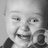

In [4]:
happy_image_path = '../data/clean_fer_2013/train/happy/Training_109676.jpg'
img = load_img(happy_image_path, color_mode="grayscale")
img

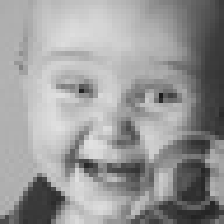

In [5]:
load_img(happy_image_path, color_mode="rgb", target_size=(224,224))

In [6]:
np.array(img).shape, preprocess_input(happy_image_path).shape

I0000 00:00:1737628433.732876     203 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


((48, 48), TensorShape([48, 48, 3]))

In [7]:
np.array(img).shape, preprocess_input(happy_image_path, resize_dimensions=(224,224)).shape

((48, 48), TensorShape([224, 224, 3]))

In [8]:
example_model = keras.applications.MobileNetV3Small(
    weights="imagenet",
    input_shape=(224,224,3)
)

x = preprocess_input(happy_image_path, resize_dimensions=(224,224))
X = np.expand_dims(x, axis=0)
prediction = example_model.predict(X)
prediction.shape

10734624/10734624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1737628443.200030     480 service.cc:148] XLA service 0x7f747c030930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737628443.200059     480 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-23 10:34:03.242101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737628443.558924     480 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-23 10:34:04.806414: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1737628446.364684     480 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(1, 1000)

In [9]:
X.shape

(1, 224, 224, 3)

In [10]:
keras.applications.mobilenet_v3.decode_predictions(prediction)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n03838899', 'oboe', np.float32(0.19695984)),
  ('n03692522', 'loupe', np.float32(0.13229686)),
  ('n04591157', 'Windsor_tie', np.float32(0.06434197)),
  ('n04317175', 'stethoscope', np.float32(0.048217837)),
  ('n02804610', 'bassoon', np.float32(0.046077117))]]

## Transfer Learning

I will do the following to make use of MobileNetV3Small for our data:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

You can see that the model has far more parameters than our scratch model but the actual trainable parameters are significantly reduced. This makes sense: we have frozen our base model and it has already been trained. We are only training the dense layer we added.

In [11]:
# 1. Instantiate base model and load pre-trained weights, specify our preferred input shape
base_model = keras.applications.MobileNetV3Small(
    weights="imagenet", # Load weights pretrained on Imagenet
    input_shape=(48,48,3),
    include_top=False # Do not include the ImageNet classifier at the top
)

# 2. Freeze the base model
base_model.trainable = False 

# 3. Create a new model on top of the output on one of the layers
inputs = keras.Input(shape=(48,48,3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Final output layer
num_categories = 7
outputs = keras.layers.Dense(num_categories, activation='softmax')(vectors)

first_model = keras.Model(inputs,outputs) 

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

first_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
first_model.summary()

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         4,039 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,159 (3.60 MB)

 Trainable params: 4,039 (15.78 KB)

 Non-trainable params: 939,120 (3.58 MB)

### Loading the datasets and training the model

I am using the same functionality as in the scratch model to load our validation and training datasets.

In [12]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [13]:
data_file_path = "../data/clean_fer_2013/"

In [14]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

,category,file_path
0,sad,../data/clean_fer_2013/train/sad/Training_8912...
1,sad,../data/clean_fer_2013/train/sad/Training_7374...
2,sad,../data/clean_fer_2013/train/sad/Training_9509...
3,sad,../data/clean_fer_2013/train/sad/Training_7259...
4,sad,../data/clean_fer_2013/train/sad/Training_3215...


In [15]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

,category,file_path
0,sad,../data/clean_fer_2013/validation/sad/PublicTe...
1,sad,../data/clean_fer_2013/validation/sad/PublicTe...
2,sad,../data/clean_fer_2013/validation/sad/PublicTe...
3,sad,../data/clean_fer_2013/validation/sad/PublicTe...
4,sad,../data/clean_fer_2013/validation/sad/PublicTe...


In [16]:
def create_label_encoder(categories):
    """Create a mapping from category names to integer indices and perform one hot encoding"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode='one_hot', 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [17]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories)

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, batch_size=32)

In [18]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [19]:
history = first_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30


2025-01-23 10:35:05.638547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 416 of 1000
2025-01-23 10:35:15.638661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 832 of 1000
2025-01-23 10:35:15.750704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.2256 - loss: 1.9411 - val_accuracy: 0.2757 - val_loss: 1.7456
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2828 - loss: 1.7844 - val_accuracy: 0.3269 - val_loss: 1.6997
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3193 - loss: 1.7118 - val_accuracy: 0.2593 - val_loss: 1.7919
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3077 - loss: 1.7378 - val_accuracy: 0.3315 - val_loss: 1.6713
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3225 - loss: 1.6956 - val_accuracy: 0.3258 - val_loss: 1.7222
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3287 - loss: 1.6912 - val_accuracy: 0.3283 - val_loss: 1.6661
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3357 - loss: 1.6796 - val_accuracy: 0.3580 - val_loss: 1.6387
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3385 - loss: 1.6643 - val_accuracy: 0.3401 - va

**Evaluation**

After 30 epochs, training accuracy has not improved beyond 0.38! The loss is still also relatively high.

Before dispensing with this model in favour of the scratch model, I will try a couple of different options.

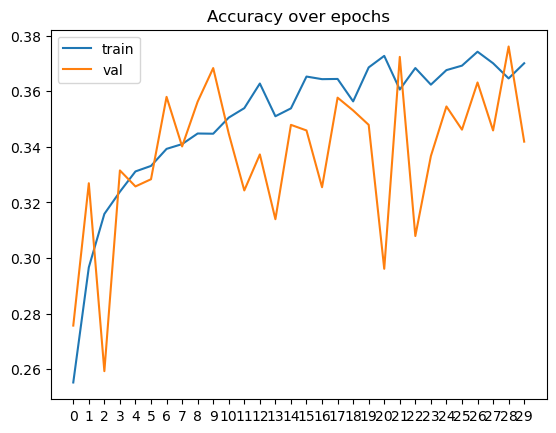

In [20]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

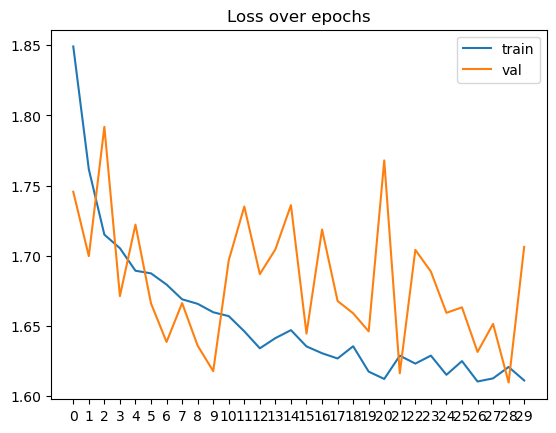

In [21]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Improvement Attempt 1: Unfreeze some of the layers in MobileNetV3

It's possible that the features from the pre-trained model are not really suited for our emotion recognition task and that we need to fien tune the base model more to our dataset: with our current configuration only the top dense layer is being tuned! 

Our base_model has 157 layers. We can try unfreezing the last 20 to see if this improves the model. You can see that this vastly increases the number of parameters being trained.

In [22]:
len(base_model.layers)

157

In [24]:
base_model_2 = keras.applications.MobileNetV3Small(
    weights="imagenet", # Load weights pretrained on Imagenet
    input_shape=(48,48,3),
    include_top=False # Do not include the ImageNet classifier at the top
)

# 2. Freeze all the base model layers except the last 20
base_model_2.trainable = True 

for layer in base_model_2.layers[:-20]:
    layer.trainable = False

# 3. Create a new model on top of the output on one of the layers
inputs = keras.Input(shape=(48,48,3))

base = base_model_2(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

# Final output layer
num_categories = 7
outputs = keras.layers.Dense(num_categories, activation='softmax')(vectors)

second_model = keras.Model(inputs,outputs) 

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

second_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
second_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         4,039 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,159 (3.60 MB)

 Trainable params: 354,775 (1.35 MB)

 Non-trainable params: 588,384 (2.24 MB)

In [25]:
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, batch_size=32)

expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [26]:
history = second_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.2326 - loss: 1.9516 - val_accuracy: 0.2001 - val_loss: 1.8574
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3568 - loss: 1.6229 - val_accuracy: 0.2214 - val_loss: 1.9536
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5386 - loss: 1.2230 - val_accuracy: 0.2010 - val_loss: 2.1798
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6952 - loss: 0.8191 - val_accuracy: 0.1915 - val_loss: 2.3033
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8563 - loss: 0.4335 - val_accuracy: 0.1883 - val_loss: 2.6266
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9206 - loss: 0.2520 - val_accuracy: 0.2027 - val_loss: 2.8419
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9588 - loss: 0.1389 - val_accuracy: 0.2016 - val_loss: 2.8669
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9829 - loss: 0.0745 - val_accuracy: 

**Evaluation**

When we unfreeze some of the lower layers, we can see that our model shows signs of overfitting, quickly performing well on the training dataset while producing more results for the validation dataset.

One way to do this is reduce the learning rate. Since we did some some improvements in accuracy, we will keep our layers unfrozen.

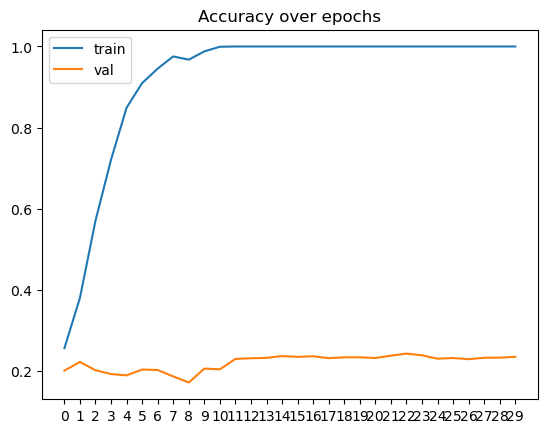

In [27]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

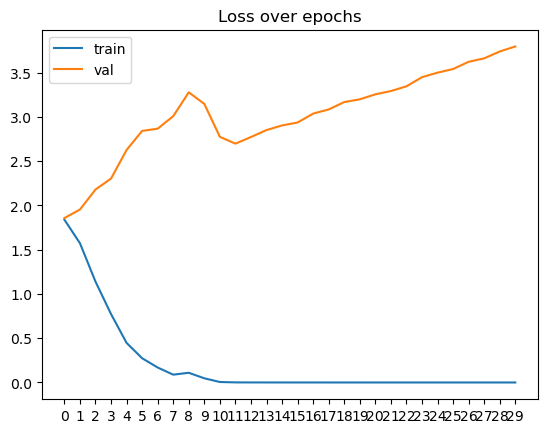

In [28]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Improvement Attempt 2: Reduce learning rate if no improvement in val loss

`ReduceLROnPlateau` is a function that will reduce the learning rate automatically after a certain number of epochs e.g.

- `monitor`: what stat to monitor. We can look at `val_loss` i.e. the change in the validation loss function and update the learning rate if this doesn't improve
- `patience`: this is the number of epochs over which we can allow the validation loss to not improve before we change it
- `factor`: the factor to reduce the learning rate by. Here we reduce it by half
- `min_lr`: Our current learning rate is the default 0.001

In [41]:
base_model_3 = keras.applications.MobileNetV3Small(
    weights="imagenet", # Load weights pretrained on Imagenet
    input_shape=(48,48,3),
    include_top=False # Do not include the ImageNet classifier at the top
)

# 2. Freeze all the base model layers except the last 20
base_model_3.trainable = True 

for layer in base_model_3.layers[:-20]:
    layer.trainable = False

# 3. Create a new model on top of the output on one of the layers
inputs = keras.Input(shape=(48,48,3))

base = base_model_3(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

# Final output layer
num_categories = 7
outputs = keras.layers.Dense(num_categories, activation='softmax')(vectors)

third_model = keras.Model(inputs,outputs) 

# Reduce learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

third_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
third_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         4,039 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,159 (3.60 MB)

 Trainable params: 354,775 (1.35 MB)

 Non-trainable params: 588,384 (2.24 MB)

In [42]:
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, batch_size=32)

expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [43]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=0.000001,
                                verbose=True)

history_3 = third_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    callbacks=[lr_scheduler]
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.1820 - loss: 2.1742 - val_accuracy: 0.1688 - val_loss: 1.9466 - learning_rate: 1.0000e-04
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2757 - loss: 1.7718 - val_accuracy: 0.2110 - val_loss: 1.8755 - learning_rate: 1.0000e-04
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3364 - loss: 1.6855 - val_accuracy: 0.2274 - val_loss: 1.8363 - learning_rate: 1.0000e-04
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3901 - loss: 1.5921 - val_accuracy: 0.2303 - val_loss: 1.8372 - learning_rate: 1.0000e-04
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4792 - loss: 1.4217 - val_accuracy: 0.2289 - val_loss: 1.8611 - learning_rate: 1.0000e-04
Epoch 6/30
834/837 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5790 - loss: 1.2490
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
837/837 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.

**Evaluation**

We can see that reducing the learning rate doesn't improve our model and it still fails to generalise: there is a large gap between the training and validation data indicating overfitting.

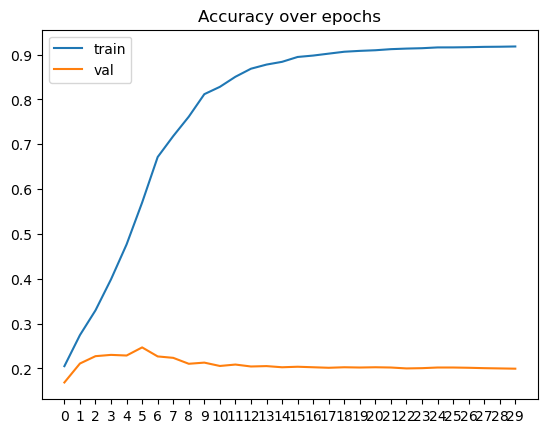

In [44]:
plt.plot(history_3.history["accuracy"], label="train")
plt.plot(history_3.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

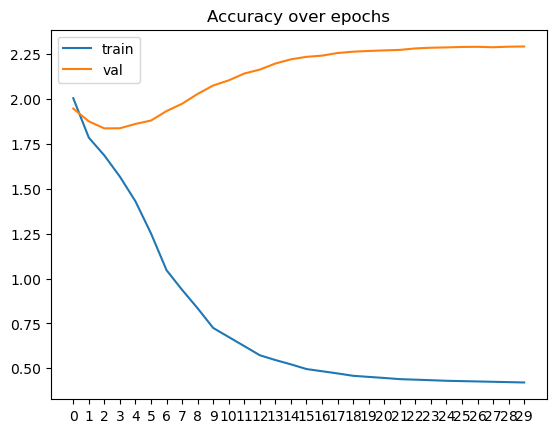

In [45]:
plt.plot(history_3.history["loss"], label="train")
plt.plot(history_3.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

## Conclusions

Despite attempting to tweak the model, our accuracy scores for the validation set never get better than about 35%, which is less than the score we were getting from the model we trained from scratch.

It's possible that the pretrained model's features just don't align well with our emotion recognition task. Whatever the underlying reason, I will opt to work on improving a model built from scratch over using a transfer model approach.